<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_04/assignments/assignment_04_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT_SCI 465: Advanced Electron Microscopy & Diffraction
## Week 03 & 04 Combined Assignment
**Classical, ML, and Deep Learning Approaches to Microscopy Analysis**

**Dataset:** DOPAD (Dataset Of nanoPArticle Detection) - TEM nanoparticle images for detection and classification  
**Dataset Source:** https://dopad.github.io/

## Objective
Compare classical computer vision, machine learning, and deep learning approaches on the same electron microscopy dataset. Progress from traditional image processing through supervised and unsupervised learning to modern deep learning, enabling direct quantitative comparison of all methods.

## Task 1 · Classical Image Analysis Pipeline
- [ ] Apply noise reduction (Gaussian, median, or FFT filtering) and compute signal-to-noise ratio before and after using $SNR = u / sigma$.
- [ ] Enhance contrast via histogram equalization or CLAHE (clip limit 0.01-0.03).
- [ ] Segment features using Otsu thresholding followed by Watershed to separate touching particles.
- [ ] Quantify morphology with `regionprops` (area, diameter, eccentricity, solidity) and export measurements to `classical_results.csv`.
- [ ] Create a four-panel figure: raw image, filtered/enhanced result, segmented labels, particle size distribution.

In [30]:
# Task 1 setup: imports and data loading
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from skimage import exposure, filters, measure, morphology, segmentation

from skimage.io import imread
import scipy
from scipy import fft
import matplotlib.pyplot as plt
import os


import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')       # <-- hard-disable Apple Metal GPU


# DOPAD dataset: download from https://dopad.github.io/docs/download/
# After extraction, adjust IMAGE_DIR to your local path

# Use absolute path to ensure it works regardless of kernel working directory
IMAGE_DIR = Path('/Users/kgeis/Documents/MSE-465/samples')

print(f"Current working directory: {os.getcwd()}")
print(f"IMAGE_DIR: {IMAGE_DIR}")
print(f"IMAGE_DIR exists: {IMAGE_DIR.exists()}")

# Example: load a TEM image from DOPAD
# For PNG/standard formats:
if IMAGE_DIR.exists():
    sample_images = sorted(list(IMAGE_DIR.glob('*.png')) + list(IMAGE_DIR.glob('*.tif')))
    if sample_images:
        raw_image = imread(str(sample_images[0]))
        print(f"Loaded: {sample_images[0].name}, Shape: {raw_image.shape}")
        print(f"Total images available: {len(sample_images)}")
    else:
        print("No images found in DOPAD directory")
else:
    raw_image = None
    print("IMAGE_DIR path not found. Please download DOPAD dataset and update path.")

Current working directory: /Users/kgeis/Documents/MSE-465/MATSCI465_KatieEisenman/Week3+4
IMAGE_DIR: /Users/kgeis/Documents/MSE-465/samples
IMAGE_DIR exists: True
Loaded: 11500X00.png, Shape: (416, 416, 4)
Total images available: 279054


In [31]:
# Task 1 processing: filtering, enhancement, segmentation, quantification
# HINTS for Task 1:
# 1. Filtering: Use filters.median() or filters.gaussian() from skimage.filters
#    Compare SNR before and after filtering to see improvement
# 2. Enhancement: Use exposure.equalize_adapthist() with clip_limit around 0.025
#    This will increase contrast without oversaturation
# 3. Segmentation: After Otsu thresholding, use scipy.ndimage.distance_transform_edt()
#    to find marker positions for Watershed
# 4. Regionprops: Pass intensity_image parameter to get min/max/mean intensity
#    Example: measure.regionprops(labels, intensity_image=enhanced_image)
# 5. Export: Use pd.DataFrame.to_csv() to save measurements

def compute_snr(image: np.ndarray) -> float:
    signal = np.mean(image)
    noise = np.std(image)
    return float(signal / noise) if noise else np.inf

if raw_image.ndim == 3: #convert to grayscale from RGB
    if raw_image.shape[2] >= 3:
        grayscale = raw_image[:,:,0]
    else:
        grayscale = np.mean(raw_image, axis=2)
else:
    grayscale = raw_image

# Filtering hint: Try median filter for salt-and-pepper noise

snr_before = compute_snr(grayscale)
print(f'SNR Before Filtering: {snr_before:.5f}')

med_filtered_image = filters.median(grayscale, footprint=morphology.disk(5))
snr_after_med = compute_snr(med_filtered_image)
print(f'SNR After Median Filtering: {snr_after_med:.5f}')

# Enhancement hint: CLAHE improves local contrast
enhanced_image = exposure.equalize_adapthist(med_filtered_image, clip_limit=0.005)
snr_after_clahe = compute_snr(enhanced_image)
print(f'SNR After CLAHE: {snr_after_clahe:.5f}')

SNR Before Filtering: 4.85289
SNR After Median Filtering: 4.91625
SNR After CLAHE: 4.91846


In [32]:
threshold = filters.threshold_otsu(enhanced_image)
binary = enhanced_image < threshold

separated = scipy.ndimage.distance_transform_edt(binary)

# Then use distance transform + watershed to separate particles
peaks = morphology.local_maxima(separated, indices=False)
coords, _ = scipy.ndimage.label(peaks)

spot_labels = segmentation.watershed(-separated, markers=coords, mask=binary)


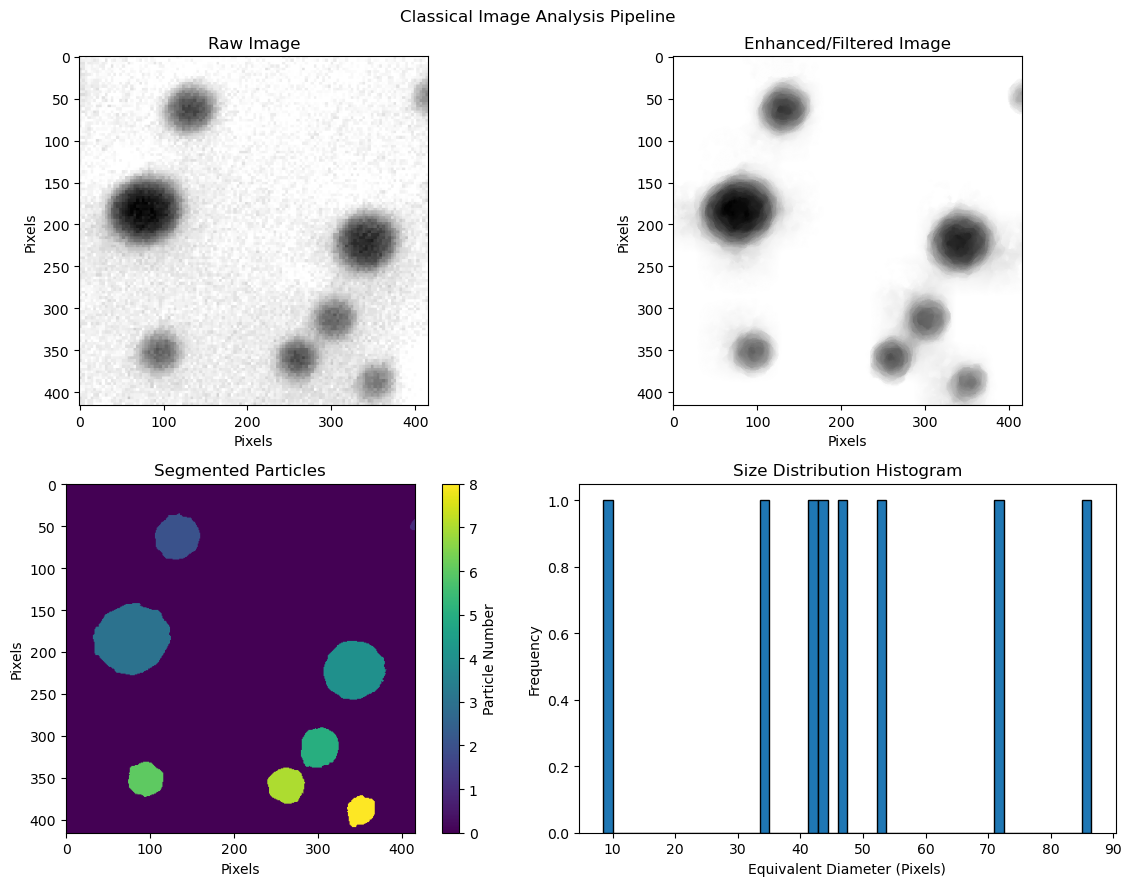

In [33]:
# Morphology hint: Extract area, perimeter, eccentricity, solidity, equivalent_diameter
spot_areas = measure.regionprops(spot_labels, intensity_image=enhanced_image)

spot_data = []

for spot in spot_areas:
    spot_data.append({'area': spot.area, 'perimeter': spot.perimeter, 'eccentricity': spot.eccentricity, 
        'solidity': spot.solidity, 'equivalent_diameter': spot.equivalent_diameter})
    


# Store in a DataFrame, then save with measurements.to_csv()
measurements = pd.DataFrame(spot_data)
measurements.to_csv('classical_results.csv', index=False)

# Visualization hint: Create 2x2 subplot figure with:
# [Raw image] [Enhanced/Filtered]
# [Segmented labels] [Size distribution histogram]
# Use imshow() for images and hist() for distribution


fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes[0, 0].imshow(raw_image, cmap='gray')
axes[0, 0].set_title("Raw Image")
axes[0, 0].set_xlabel('Pixels')
axes[0, 0].set_ylabel('Pixels')

axes[0, 1].imshow(enhanced_image, cmap='gray')
axes[0, 1].set_title("Enhanced/Filtered Image")
axes[0, 1].set_xlabel('Pixels')
axes[0, 1].set_ylabel('Pixels')

im = axes[1, 0].imshow(spot_labels, cmap='viridis')
axes[1, 0].set_title("Segmented Particles")
axes[1, 0].set_xlabel('Pixels')
axes[1, 0].set_ylabel('Pixels')
fig.colorbar(im, ax=axes[1, 0], label='Particle Number')

#Make histogram for 4th image
axes[1, 1].hist(measurements['equivalent_diameter'], bins=50, edgecolor='black')
axes[1, 1].set_title("Size Distribution Histogram")
axes[1, 1].set_xlabel('Equivalent Diameter (Pixels)')
axes[1, 1].set_ylabel('Frequency')

fig.suptitle('Classical Image Analysis Pipeline')

plt.tight_layout()
plt.show()

#Save image
fig.savefig("Task1.png", dpi=300, bbox_inches='tight')



## Task 2 · Machine Learning Approaches
- [ ] Extract hand-crafted features: edges (Canny or Sobel), blobs (LoG), textures (LBP or GLCM) to build a feature matrix with at least 10 descriptors per region.
- [ ] Perform feature selection using Random Forest importance or correlation analysis; retain the top 5-7 discriminative features.
- [ ] Supervised: label data into two or more classes (≥50 samples), train SVM and Random Forest, then report precision, recall, F1-score, and confusion matrices.
- [ ] Unsupervised: run k-Means (k ∈ {3, 5, 7}) and visualize using PCA or t-SNE; compute silhouette scores.
- [ ] Compare ML outputs with classical segmentation regarding particle counts, accuracy, and runtime; export to `ml_results.csv`.

In [34]:
# Task 2: feature extraction and ML pipelines
from skimage.feature import canny, blob_dog, local_binary_pattern
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# HINTS for Task 2:
# 1. Feature extraction: For each detected region, compute:
#    - Area, perimeter, equivalent diameter, eccentricity, solidity (from regionprops)
#    - Mean and std intensity (intensity-based features)
#    - Edge features: number of edges detected by Canny filter
#    - Texture: Local Binary Pattern variance
#    - Circularity = 4*pi*area / perimeter^2
#    - Total: 10+ features per region


# def crop_to_bbox(image, bbox):
#     minr, minc, maxr, maxc = bbox
#     return image[minr:maxr, minc:maxc]

#DO LATER
# def edge_ratio(regmask, image):
#     edges = canny(region)
#     edge_rat = np.sum(edges) / area



def identify_features(image, region):
    #basic regionpropos
    area = region.area
    perimeter = region.perimeter
    equivalent_diameter = region.equivalent_diameter
    eccentricity = region.eccentricity
    solidity = region.solidity
    if perimeter > 0:
        circularity = 4*np.pi*area / perimeter**2
    else:
        circularity = 0
    min = region.intensity_min
    max = region.intensity_max
    mean = region.mean_intensity
    std = region.intensity_std

    # edge_ratio = region.edge_ratio


    return {
        'area': area, 'perimeter' : perimeter, 'equivalent_diameter':equivalent_diameter, 
        'eccentricity': eccentricity, 'solidity': solidity, 'circularity': circularity,
        'intensity_min': min, 'intensity_max': max, 'intensity_mean': mean,
        'intensity_std': std}

def build_dataset(image_files):
    feature_list = []
    label_list = []

    for idx, file in enumerate(image_files[:50]): #Can change number, depends how many images you want to pull
        pic = imread(str(file))
        #Copied code I used in Task 1
        if pic.ndim == 3: #convert to grayscale from RGB
            if pic.shape[2] >= 3:
                grayscale = pic[:,:,0]
            else:
                grayscale = np.mean(pic, axis=2)
        else:
            grayscale = pic
        
        med_filtered_image = filters.median(grayscale, footprint=morphology.disk(4))
        enhanced_image = exposure.equalize_adapthist(med_filtered_image, clip_limit=0.015)

        threshold = filters.threshold_otsu(enhanced_image)
        binary = enhanced_image < threshold

        separated = scipy.ndimage.distance_transform_edt(binary)

        peaks = morphology.local_maxima(separated, indices=False)
        coords, _ = scipy.ndimage.label(peaks)

        spot_labels = segmentation.watershed(-separated, markers=coords, mask=binary)

        spot_areas = measure.regionprops(spot_labels, intensity_image=enhanced_image)

        for spot in spot_areas:
            if spot.area > 5:
                features = identify_features(enhanced_image, spot)
                feature_list.append(features)
                label_list.append(idx)

    return feature_list, label_list
        
features_dataset, label_list = build_dataset(sample_images)

feature_df = pd.DataFrame(features_dataset)
print(f"Extracted {len(feature_df)} regions from {len(sample_images[:50])} images")
print(feature_df.describe())        
                  

Extracted 32962 regions from 50 images
               area     perimeter  equivalent_diameter  eccentricity  \
count  32962.000000  32962.000000         32962.000000  32962.000000   
mean      85.920393     29.653749             8.565660      0.719751   
std      275.963419     26.522734             6.002316      0.160403   
min        6.000000      4.000000             2.763953      0.000000   
25%       22.000000     16.071068             5.292567      0.635151   
50%       44.000000     24.485281             7.484821      0.743344   
75%       83.000000     35.899495            10.280023      0.832995   
max     7882.000000    509.895490           100.178212      1.000000   

           solidity   circularity  intensity_min  intensity_max  \
count  32962.000000  32962.000000   32962.000000   32962.000000   
mean       0.895488      1.003568       0.464734       0.585637   
std        0.064764      0.351540       0.096676       0.047707   
min        0.416667      0.101063       0.00

In [35]:
# 2. Feature selection: Train a RandomForestClassifier and get feature_importances_
#    Keep top 5-7 features with highest importance scores
#    Hint: importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

def select_top_features_by_importance(rf_model, feature_df, k=6):
    importances = rf_model.feature_importances_
    feat_names = np.array(feature_df.columns)

    importances_df = (
        pd.DataFrame({'feature': feat_names, 'importance': importances})
        .sort_values('importance', ascending=False).reset_index(drop=True))

    k = max(1, min(k, len(importances_df))) #pick top features
    top_features = importances_df['feature'].head(k).tolist()

    reduced_df = feature_df[top_features].copy()

    return top_features, importances_df, reduced_df

#Sort into large and small particles
mean_area = feature_df['area'].mean()
labels = (feature_df['area'] > mean_area).astype(int)

rf_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importance.fit(feature_df, labels)

top_features, fi_df, feature_df_top = select_top_features_by_importance(
    rf_importance, feature_df, k=6
)

print("Top features:", top_features)
print(fi_df.head(10))  # full ranking (top 10 shown)


Top features: ['area', 'equivalent_diameter', 'perimeter', 'circularity', 'intensity_std', 'intensity_min']
               feature  importance
0                 area    0.391173
1  equivalent_diameter    0.345862
2            perimeter    0.197488
3          circularity    0.044070
4        intensity_std    0.012349
5        intensity_min    0.006360
6             solidity    0.001532
7         eccentricity    0.001081
8        intensity_max    0.000061
9       intensity_mean    0.000024


In [36]:
# 3. Supervised ML:
#    - Split data into train/test (80/20)
#    - Scale features using StandardScaler()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_df_top)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

Training set size: 26369
Test set size: 6593
Class distribution - Train: [20147  6222]
Class distribution - Test: [5037 1556]


SVM Precision Score: 0.9980494148244473
SVM F1 Score 0.9922430510665805
SVM Recall Score: 0.9980494148244473
SVM Confusion Matrix: [[5034    3]
 [  21 1535]]


Text(0.5, 23.52222222222222, 'Predicted Label')

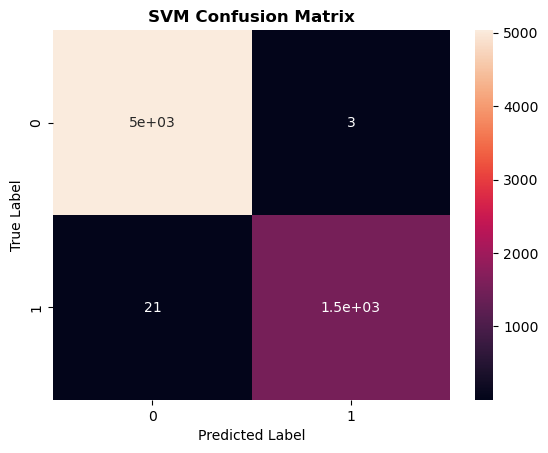

In [37]:
#    - Train SVM with kernel='rbf' and Random Forest with n_estimators=100
#    - Compute F1-score: metrics.f1_score(y_true, y_pred)
#    - Create confusion matrix: metrics.confusion_matrix(y_true, y_pred)


svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_predicted = svm_model.predict(X_test)

#Precision of SVM
precision_svm = precision_score(y_test, svm_predicted)
print(f'SVM Precision Score: {precision_svm}')

#F1-score of SVM
f1_score_svm = f1_score(y_test, svm_predicted)
print(f'SVM F1 Score {f1_score_svm}')

#Recall score of SVM
recall_svm = recall_score(y_test, svm_predicted)
print(f'SVM Recall Score: {precision_svm}')

#Confusion Matrix of SVM
confusion_svm = confusion_matrix(y_test, svm_predicted)
print(f'SVM Confusion Matrix: {confusion_svm}')
sns.heatmap(confusion_svm, annot=True) #normalize later
plt.title('SVM Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

RF Precision Score: 1.0
RF F1 Score 1.0
RF Recall Score: 1.0
RF Confusion Matrix: [[5037    0]
 [   0 1556]]


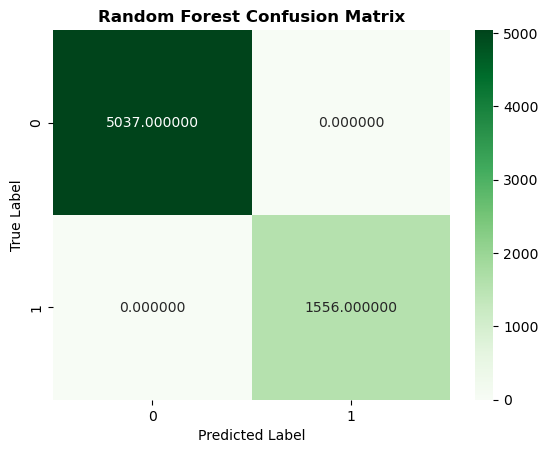

In [38]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(X_train, y_train)
RF_predicted = RF_model.predict(X_test)

#Precision of SVM
precision_RF = precision_score(y_test, RF_predicted)
print(f'RF Precision Score: {precision_RF}')

#F1-score of SVM
f1_score_RF = f1_score(y_test, RF_predicted)
print(f'RF F1 Score {f1_score_RF}')

#Recall score of SVM
recall_RF = recall_score(y_test, RF_predicted)
print(f'RF Recall Score: {precision_RF}')

#Confusion Matrix of SVM
confusion_RF = confusion_matrix(y_test, RF_predicted)
cm_RF_normalized = confusion_RF.astype('float') / confusion_RF.sum(axis=1)[:, np.newaxis]
RF_cm = sns.heatmap(confusion_RF, annot=True, fmt='2f', cmap='Greens', cbar=True)
plt.title('Random Forest Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
print(f'RF Confusion Matrix: {confusion_RF}')

0.37492108124865153
0.3173239997966933
0.27640370575175477


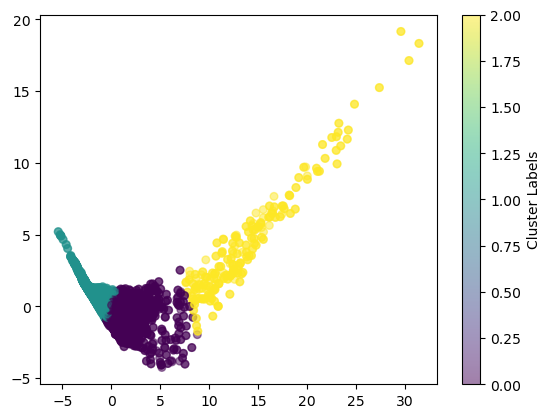

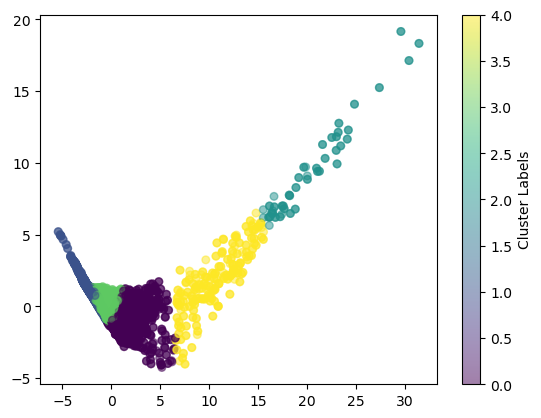

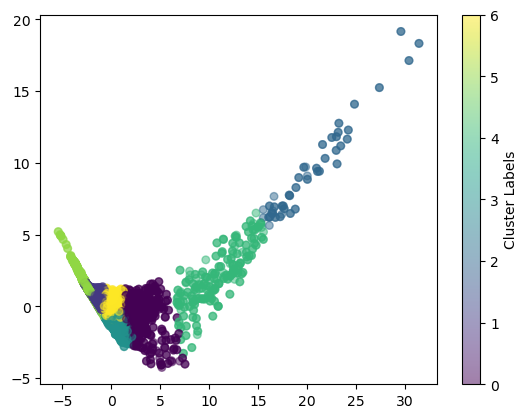

In [39]:
# 4. Unsupervised ML:
#    - Run KMeans for k in [3, 5, 7]
#    - Compute silhouette_score(X_scaled, clusters) for each k
#    - Use PCA(n_components=2) to project to 2D for visualization
#    - Plot scatter with cluster labels as colors

# 5. Export: Save results to ml_results.csv with columns:
#    [Method, F1-Score, Precision, Recall, Silhouette_Score]

k_list = [3, 5, 7]
for i in k_list:
    clusters = KMeans(n_clusters=i, random_state=42).fit_predict(X_scaled)
    silhouette_score_i = silhouette_score(X_scaled, clusters) #For each k
    print(silhouette_score_i)
    X_pca = PCA(n_components=2).fit_transform(X_scaled)
    plt.figure()
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=30, alpha=0.5)
    plt.colorbar(label='Cluster Labels')

# TODO: evaluate models, generate confusion matrices, export results
# ml_results = pd.DataFrame()
# ml_results.to_csv('ml_results.csv', index=False)

# Confusion matrix visualization hint:
# Use seaborn.heatmap(confusion_matrix, annot=True) for nice heatmap display

# TODO: run unsupervised clustering and visualize embeddings
# K-Means hint: clusters = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
# PCA visualization: X_pca = PCA(n_components=2).fit_transform(X_scaled)
#                   plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters)

## Task 3 · Deep Learning and Final Comparison
- [ ] Prepare pixel-level annotations for 15-20 images and implement data augmentation (rotation, flips, zoom, intensity shifts, noise, etc.; 5+ variants).
- [ ] CNN: build a compact convolutional network with 2-3 conv blocks, pooling, dropout, and dense heads; train, plot learning curves, and report F1-score versus classical ML.
- [ ] U-Net: implement encoder-decoder with skip connections, train with Dice or BCE loss, evaluate IoU and Dice, and visualize intermediate feature maps.
- [ ] Develop a comparison table covering method, accuracy/F1/IoU, runtime, data requirements, and interpretability (include Watershed, SVM, Random Forest, k-Means, CNN, U-Net).
- [ ] Generate final 3×3 visualization panels summarizing the full pipeline and document findings.
- [ ] Author README.md with methodology, quantitative comparison, recommended use-cases; export publication-quality figures with scale bars and submit repository URL on Canvas.

In [40]:
# Task 3: deep learning workflow templates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


# HINTS for Task 3:
# 1. Data preparation:
#    - Use ImageDataGenerator with augmentation parameters:
#      rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
#      zoom_range=0.2, fill_mode='reflect'
#    - Normalize pixel values to [0, 1]
#    - Use flow_from_directory() or flow() from keras preprocessing

import os
import numpy as np
import pandas as pd
from pathlib import Path

from skimage.io import imread
from skimage import filters, morphology, exposure, segmentation, measure
import scipy.ndimage as ndi
import imageio.v2 as iio  # for saving PNGs

# ---------- Helpers (reuse your pipeline) ----------

def segment_and_enhance(img):
    """Median -> CLAHE -> Otsu -> distance -> watershed. Returns (labels, enhanced_image)."""
    # Ensure grayscale
    if img.ndim == 3:
        gray = img[:, :, 0] if img.shape[2] >= 3 else np.mean(img, axis=2)
    else:
        gray = img

    med = filters.median(gray, footprint=morphology.disk(4))
    enhanced = exposure.equalize_adapthist(med, clip_limit=0.015)

    thresh = filters.threshold_otsu(enhanced)
    binary = enhanced < thresh

    dist = ndi.distance_transform_edt(binary)
    peaks = morphology.local_maxima(dist)              # boolean mask of local maxima
    markers, _ = ndi.label(peaks)                      # label maxima as markers
    labels = segmentation.watershed(-dist, markers=markers, mask=binary)
    return labels, enhanced


def crop_patch(image2d, cy, cx, size=128):
    """
    Crop a centered (size x size) patch from image2d at (cy, cx).
    Pads with 'reflect' if near borders.
    """
    h, w = image2d.shape[:2]
    half = size // 2
    ymin, ymax = cy - half, cy + half
    xmin, xmax = cx - half, cx + half

    pad_y0 = max(0, -ymin)
    pad_x0 = max(0, -xmin)
    pad_y1 = max(0, ymax - h)
    pad_x1 = max(0, xmax - w)

    if pad_y0 or pad_y1 or pad_x0 or pad_x1:
        image2d = np.pad(image2d, ((pad_y0, pad_y1), (pad_x0, pad_x1)), mode='reflect')
        ymin += pad_y0; ymax += pad_y0
        xmin += pad_x0; xmax += pad_x0

    patch = image2d[ymin:ymax, xmin:xmax]
    return patch


def make_small_large_patch_dataset(
    image_files,
    out_dir="patches_small_large",
    patch_size=128,
    min_area=5
):
    """
    Build a dataset with class folders 'small' and 'large' based on the global mean area.
    Saves patches cropped from the enhanced image around each region centroid.
    Returns the global mean area used as threshold.
    """
    out_dir = Path(out_dir)
    (out_dir / "small").mkdir(parents=True, exist_ok=True)
    (out_dir / "large").mkdir(parents=True, exist_ok=True)

    # ---------- Pass 1: compute global mean area ----------
    all_areas = []
    for i, fp in enumerate(image_files):
        img = imread(str(fp))
        labels, enhanced = segment_and_enhance(img)
        for r in measure.regionprops(labels, intensity_image=enhanced):
            if r.area > min_area:
                all_areas.append(r.area)

    if not all_areas:
        raise ValueError("No regions found across the provided images. Check preprocessing/thresholding.")

    area_mean = float(np.mean(all_areas))
    print(f"[INFO] Global mean area across dataset = {area_mean:.3f} pixels^2")

    # ---------- Pass 2: save patches into class folders ----------
    manifest_rows = []
    saved = 0

    for i, fp in enumerate(image_files):
        img = imread(str(fp))
        labels, enhanced = segment_and_enhance(img)
        regions = measure.regionprops(labels, intensity_image=enhanced)

        for r in regions:
            if r.area <= min_area:
                continue

            # Class based on area vs global mean
            cls = "small" if r.area < area_mean else "large"

            cy, cx = map(int, r.centroid)  # (row, col)
            patch = crop_patch(enhanced, cy, cx, size=patch_size)

            # Save as uint8 PNG (enhanced image is in [0,1])
            patch_u8 = (np.clip(patch, 0, 1) * 255).astype(np.uint8)
            fname = f"img{i:03d}_reg{r.label:04d}_{cls}.png"
            iio.imwrite(out_dir / cls / fname, patch_u8)

            manifest_rows.append({
                "filename": fname,
                "image_index": i,
                "region_label": int(r.label),
                "area": float(r.area),
                "centroid_y": float(r.centroid[0]),
                "centroid_x": float(r.centroid[1]),
                "class": cls
            })
            saved += 1

    # Write manifest
    pd.DataFrame(manifest_rows).to_csv(out_dir / "manifest.csv", index=False)
    print(f"[DONE] Saved {saved} patches into '{out_dir}/small' and '{out_dir}/large'.")
    return area_mean


In [41]:
import shutil, os
out_dir = "patches_small_large"
if os.path.isdir(out_dir):
    shutil.rmtree(out_dir)  # CAREFUL: deletes the folder permanently

area_mean = make_small_large_patch_dataset(
    image_files=sample_images[:20],
    out_dir="patches_small_large",
    patch_size=128,                  # adjust if particles are bigger/smaller
    min_area=5
)

[INFO] Global mean area across dataset = 121.275 pixels^2
[DONE] Saved 6850 patches into 'patches_small_large/small' and 'patches_small_large/large'.


In [42]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.2
)

train_ds = datagen.flow_from_directory(
    "patches_small_large",
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=8,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_ds = datagen.flow_from_directory(
    "patches_small_large",
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

num_classes = train_ds.num_classes  # should be 2 (small, large)
print(num_classes)

Found 5480 images belonging to 2 classes.
Found 1370 images belonging to 2 classes.
2


In [43]:
# 2. CNN Architecture (simple but effective):
#    - Conv2D(32, 3x3) + BatchNorm + ReLU + MaxPool(2x2)
#    - Conv2D(64, 3x3) + BatchNorm + ReLU + MaxPool(2x2)
#    - Flatten + Dense(128) + Dropout(0.5) + Dense(num_classes)
#    - Compile with optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']
#    - Train with model.fit(train_dataset, validation_data=val_dataset, epochs=20)

from tensorflow.keras import backend as K
K.clear_session()

cnn_model = keras.Sequential([
    keras.Input(shape=(128, 128, 1)),         
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print('Model Compiled.')

Model Compiled.


In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20, 
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20


/Users/kgeis/miniconda3/envs/matsci465/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


685/685 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.8106 - loss: 1.7836 - val_accuracy: 0.8292 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 2/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.8303 - loss: 0.4770 - val_accuracy: 0.8307 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 3/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 62s 90ms/step - accuracy: 0.8305 - loss: 0.4654 - val_accuracy: 0.8307 - val_loss: 0.4551 - learning_rate: 0.0010
Epoch 4/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8351 - loss: 0.4513
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
685/685 ━━━━━━━━━━━━━━━━━━━━ 62s 90ms/step - accuracy: 0.8307 - loss: 0.4583 - val_accuracy: 0.8307 - val_loss: 0.4552 - learning_rate: 0.0010
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 3.


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


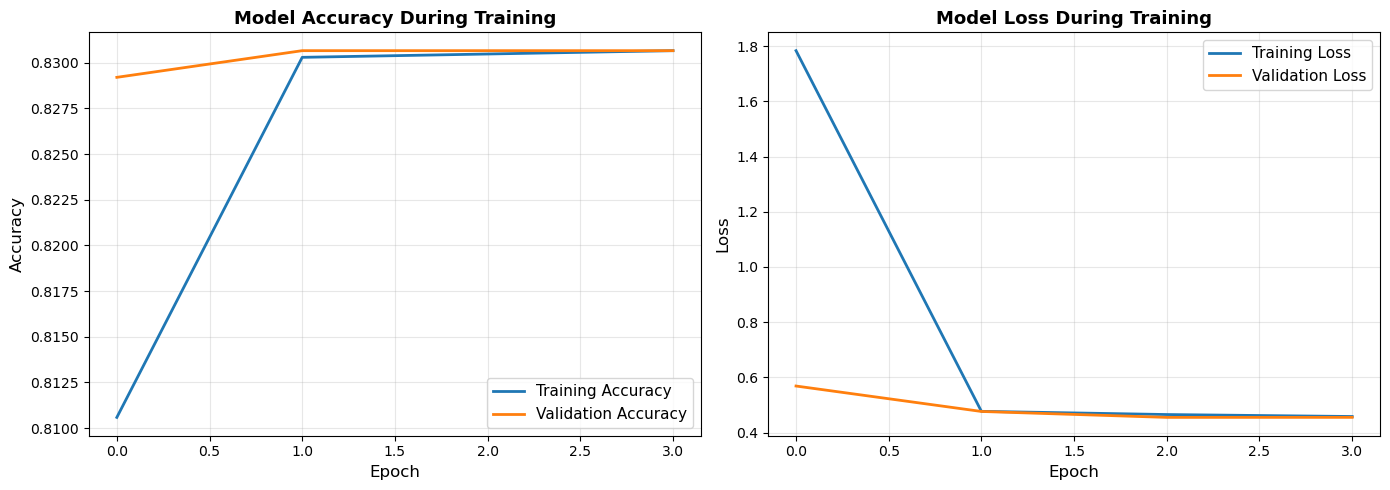


Training Summary:
Final Training Accuracy: 0.8307
Final Validation Accuracy: 0.8307
Final Training Loss: 0.4583
Final Validation Loss: 0.4552
Total Epochs Trained: 4


In [45]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

print(history.history.keys())

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy During Training', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss During Training', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print("\nTraining Summary:")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")

In [46]:
# 3. U-Net Architecture (for segmentation):
#    - Encoder: Conv -> MaxPool (downsampling)
#    - Decoder: UpSampling -> Conv (upsampling)
#    - Skip connections: concatenate encoder features with decoder features
#    - Output: single channel with sigmoid activation (binary segmentation)
#    - Loss: keras.losses.BinaryCrossentropy() or Dice loss

# U-Net hint: Build encoder (downsampling) then decoder (upsampling) with skip connections
# Encoder:  Conv -> ReLU -> MaxPool (4 levels)
# Decoder:  UpSampling -> Conv + concatenate from encoder
# Output:   Conv(1, 1x1, sigmoid) for binary segmentation

# TODO: train U-Net, compute IoU and Dice, visualize feature maps
# U-Net metrics hint:
# y_pred = unet_model.predict(X_test)
# iou = jaccard_score(y_test.flatten(), (y_pred > 0.5).flatten())
# dice = f1_score(y_test.flatten(), (y_pred > 0.5).flatten())

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input

def build_unet(input_size=(128, 128, 1), num_filters_start=32):
    inputs = Input(input_size)

    # -------- Encoder (4 levels of pooling) --------
    # Level 1
    c1 = layers.Conv2D(num_filters_start, 3, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    c1 = layers.Conv2D(num_filters_start, 3, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Activation('relu')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    # Level 2
    c2 = layers.Conv2D(num_filters_start*2, 3, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    c2 = layers.Conv2D(num_filters_start*2, 3, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Activation('relu')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    # Level 3
    c3 = layers.Conv2D(num_filters_start*4, 3, padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    c3 = layers.Conv2D(num_filters_start*4, 3, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Activation('relu')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    # Level 4  <-- add this block to meet "4 levels"
    c4 = layers.Conv2D(num_filters_start*8, 3, padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    c4 = layers.Conv2D(num_filters_start*8, 3, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Activation('relu')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # -------- Bottleneck --------
    b = layers.Conv2D(num_filters_start*16, 3, padding='same')(p4)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)
    b = layers.Conv2D(num_filters_start*16, 3, padding='same')(b)
    b = layers.BatchNormalization()(b)
    b = layers.Activation('relu')(b)

    # -------- Decoder (mirror 4 levels) --------
    u5 = layers.UpSampling2D(2)(b)
    u5 = layers.Concatenate()([u5, c4])
    d5 = layers.Conv2D(num_filters_start*8, 3, padding='same')(u5)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Activation('relu')(d5)
    d5 = layers.Conv2D(num_filters_start*8, 3, padding='same')(d5)
    d5 = layers.BatchNormalization()(d5)
    d5 = layers.Activation('relu')(d5)

    u6 = layers.UpSampling2D(2)(d5)
    u6 = layers.Concatenate()([u6, c3])
    d6 = layers.Conv2D(num_filters_start*4, 3, padding='same')(u6)
    d6 = layers.BatchNormalization()(d6)
    d6 = layers.Activation('relu')(d6)
    d6 = layers.Conv2D(num_filters_start*4, 3, padding='same')(d6)
    d6 = layers.BatchNormalization()(d6)
    d6 = layers.Activation('relu')(d6)

    u7 = layers.UpSampling2D(2)(d6)
    u7 = layers.Concatenate()([u7, c2])
    d7 = layers.Conv2D(num_filters_start*2, 3, padding='same')(u7)
    d7 = layers.BatchNormalization()(d7)
    d7 = layers.Activation('relu')(d7)
    d7 = layers.Conv2D(num_filters_start*2, 3, padding='same')(d7)
    d7 = layers.BatchNormalization()(d7)
    d7 = layers.Activation('relu')(d7)

    u8 = layers.UpSampling2D(2)(d7)
    u8 = layers.Concatenate()([u8, c1])
    d8 = layers.Conv2D(num_filters_start, 3, padding='same')(u8)
    d8 = layers.BatchNormalization()(d8)
    d8 = layers.Activation('relu')(d8)
    d8 = layers.Conv2D(num_filters_start, 3, padding='same')(d8)
    d8 = layers.BatchNormalization()(d8)
    d8 = layers.Activation('relu')(d8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d8)
    model = models.Model(inputs, outputs, name="UNet")
    return model

# Build U-Net model
print("Creating U-Net model...")
unet_model = build_unet(input_size=(128, 128, 1), num_filters_start=32)

# print("\nU-Net Architecture Summary:")
# unet_model.summary()

# Count parameters
total_params = unet_model.count_params()
print(f"\nTotal U-Net Parameters: {total_params:,}")

Creating U-Net model...

Total U-Net Parameters: 7,857,857


In [47]:
#Generate UNet Data

import os
from pathlib import Path
import numpy as np

from skimage.io import imread
from skimage import filters, morphology, exposure, segmentation
from skimage.transform import resize
import scipy.ndimage as ndi


def _to_gray(img):
    """Return 2D grayscale from image (channels-last if needed)."""
    if img.ndim == 3:
        # For TEM data, we can use a single channel (or np.mean across channels).
        if img.shape[2] >= 1:
            return img[:, :, 0]
        else:
            return img.mean(axis=2)
    return img


def _enhance_image(gray, median_disk=3, clahe_clip=0.015):
    """Median filter + CLAHE; output float32 in [0,1]."""
    med = filters.median(gray, footprint=morphology.disk(median_disk))
    enh = exposure.equalize_adapthist(med, clip_limit=clahe_clip)  # float in [0,1]
    return enh.astype(np.float32)


def _resize_image(img, target_hw):
    """Resize image (float) with bilinear filtering + anti-aliasing."""
    return resize(
        img, target_hw, order=1, mode='reflect',
        anti_aliasing=True, preserve_range=True
    ).astype(np.float32)


def _resize_mask(mask, target_hw):
    """Resize mask (binary) with nearest-neighbor; keep {0,1}."""
    m = resize(
        mask.astype(np.uint8), target_hw, order=0,  # nearest neighbor
        mode='edge', anti_aliasing=False, preserve_range=True
    )
    return (m >= 0.5).astype(np.uint8)


def _proxy_mask_from_watershed(enhanced, min_area=5):
    """Generate a binary mask via Otsu + distance + watershed (proxy GT)."""
    thr = filters.threshold_otsu(enhanced)
    binary = enhanced < thr
    dist = ndi.distance_transform_edt(binary)
    peaks = morphology.local_maxima(dist)
    markers, _ = ndi.label(peaks)
    labels = segmentation.watershed(-dist, markers=markers, mask=binary)
    mask = (labels > 0).astype(np.uint8)

    # Optional: remove small objects (helps clean up noise)
    if min_area and min_area > 0:
        mask = morphology.remove_small_objects(mask.astype(bool), min_size=min_area).astype(np.uint8)
    return mask


def build_unet_XY(
    image_dir,
    mask_dir=None,
    target_size=(128, 128),
    limit=None,
    generate_proxy_masks=False,
    median_disk=3,
    clahe_clip=0.015,
):
    """
    Build U-Net-ready arrays:
      X: (N, H, W, 1) float32 in [0,1]
      Y: (N, H, W, 1) uint8  in {0,1}

    Parameters
    ----------
    image_dir : str or Path
        Directory containing raw images (no subfolders required).
    mask_dir : str or Path or None
        Directory containing mask images; filenames must match image basenames in image_dir.
        If None and generate_proxy_masks=True, proxy masks will be generated.
    target_size : (int, int)
        (height, width) for U-Net input (e.g., (128,128) or (256,256)).
    limit : int or None
        If set, only process first 'limit' images.
    generate_proxy_masks : bool
        If True and mask_dir is None, create masks from watershed (proxy labels).
    median_disk : int
        Disk radius for median filter.
    clahe_clip : float
        CLAHE clip limit.

    Returns
    -------
    X : np.ndarray
        (N, H, W, 1) float32 in [0,1]
    Y : np.ndarray
        (N, H, W, 1) uint8 in {0,1}
    """
    image_dir = Path(image_dir)
    mask_dir = Path(mask_dir) if mask_dir else None

    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    img_paths = sorted([p for p in image_dir.iterdir() if p.suffix.lower() in exts])
    if limit:
        img_paths = img_paths[:limit]

    if len(img_paths) == 0:
        raise RuntimeError(f"No images found in {image_dir}")

    X_list, Y_list = [], []

    for p in img_paths:
        # ---- load & preprocess image ----
        img = imread(str(p))
        gray = _to_gray(img)
        enhanced = _enhance_image(gray, median_disk=median_disk, clahe_clip=clahe_clip)
        enh_resized = _resize_image(enhanced, target_size)
        X_list.append(enh_resized[..., None])  # (H, W, 1)

        # ---- load or generate mask ----
        if mask_dir is not None:
            mpath = mask_dir / p.name  # expects same filename
            if not mpath.exists():
                raise FileNotFoundError(f"Mask not found for {p.name} in {mask_dir}")
            m_raw = imread(str(mpath))
            if m_raw.ndim == 3:
                m_raw = _to_gray(m_raw)
            # If stored as 0/255 -> binarize to {0,1}
            m_bin = (m_raw >= 127.5).astype(np.uint8)
            m_resized = _resize_mask(m_bin, target_size)
            Y_list.append(m_resized[..., None])

        elif generate_proxy_masks:
            m_proxy = _proxy_mask_from_watershed(enhanced)
            m_resized = _resize_mask(m_proxy, target_size)
            Y_list.append(m_resized[..., None])
        else:
            raise ValueError("No masks: provide mask_dir or set generate_proxy_masks=True")

    X = np.stack(X_list).astype(np.float32)      # (N, H, W, 1), [0,1]
    Y = np.stack(Y_list).astype(np.float32)        # (N, H, W, 1), {0,1}
    return X, Y

# Build U-Net input X from the 'samples' folder, using first 100 images
IMAGE_DIR = '/Users/kgeis/Documents/MSE-465/samples'

X, Y = build_unet_XY(
    image_dir=IMAGE_DIR,
    mask_dir=None,
    target_size=(128, 128),
    limit=100,
    generate_proxy_masks=True,  # <-- proxy labels
    median_disk=3,
    clahe_clip=0.015
)

X_train = X
X_test = X[80:, :, :, :]
Y_train = Y
Y_test = Y[80:, :, :, :]

In [48]:
def dice_loss(y_true, y_pred, smooth=1.0):
    """
    Dice Loss = 1 - Dice Coefficient
    Dice Coefficient = 2 * |X ∩ Y| / (|X| + |Y|)
    """
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_coef = (2.0 * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )
    return 1.0 - dice_coef

def dice_coefficient(y_true, y_pred, smooth=1.0):
    """Dice Coefficient metric (for monitoring during training)"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )

def iou_metric(y_true, y_pred, smooth=1.0):
    """Intersection over Union (Jaccard Index)"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Compile U-Net model
unet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=dice_loss,  # Use Dice Loss for segmentation
    metrics=['binary_accuracy', dice_coefficient, iou_metric]
)

In [49]:
#Train UNet

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Training U-Net model...")
print(f"Training samples: {len(X_train)}")
print(f"Validation split: 20%")

unet_history = unet_model.fit(
    X_train, Y_train,
    batch_size=8,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete!")



Training U-Net model...
Training samples: 100
Validation split: 20%
Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 879ms/step - binary_accuracy: 0.7214 - dice_coefficient: 0.6322 - iou_metric: 0.4677 - loss: 0.3678 - val_binary_accuracy: 0.5685 - val_dice_coefficient: 0.2571 - val_iou_metric: 0.1475 - val_loss: 0.7418 - learning_rate: 0.0010
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 989ms/step - binary_accuracy: 0.8314 - dice_coefficient: 0.7552 - iou_metric: 0.6071 - loss: 0.2448 - val_binary_accuracy: 0.5705 - val_dice_coefficient: 0.2716 - val_iou_metric: 0.1572 - val_loss: 0.7273 - learning_rate: 0.0010
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - binary_accuracy: 0.8687 - dice_coefficient: 0.7946 - iou_metric: 0.6594 - loss: 0.2054 - val_binary_accuracy: 0.5716 - val_dice_coefficient: 0.2935 - val_iou_metric: 0.1720 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 948ms/step - binary_accuracy: 0.8815 - dice_coefficient: 0.8143 - iou_metric: 0.6

In [50]:
# Evaluate on test set
print("Evaluating U-Net on test set...")
test_results = unet_model.evaluate(X_test, Y_test, verbose=0)

print(f"\nTest Set Performance:")
print(f"Test Loss (Dice): {test_results[0]:.4f}")
print(f"Test Binary Accuracy: {test_results[1]:.4f}")
print(f"Test Dice Coefficient: {test_results[2]:.4f}")
print(f"Test IoU: {test_results[3]:.4f}")

# Make predictions on test set
y_pred = unet_model.predict(X_test, verbose=0)

# Apply threshold to get binary masks (threshold = 0.5)
y_pred_binary = (y_pred > 0.5).astype(np.float32)

# Calculate metrics for each test sample
dice_scores = []
iou_scores = []

for i in range(len(X_test)):
    # Flatten for metric calculation
    y_true_flat = Y_test[i].flatten()
    y_pred_flat = y_pred_binary[i].flatten()
    
    # Dice coefficient
    dice = (2 * np.sum(y_true_flat * y_pred_flat)) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-7)
    dice_scores.append(dice)
    
    # IoU
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    iou = intersection / (union + 1e-7)
    iou_scores.append(iou)

print(f"\nPer-Sample Metrics:")
print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f} ± {np.std(dice_scores):.4f}")
print(f"Mean IoU: {np.mean(iou_scores):.4f} ± {np.std(iou_scores):.4f}")
print(f"Min IoU: {np.min(iou_scores):.4f}")
print(f"Max IoU: {np.max(iou_scores):.4f}")

Evaluating U-Net on test set...

Test Set Performance:
Test Loss (Dice): 0.5143
Test Binary Accuracy: 0.7527
Test Dice Coefficient: 0.4857
Test IoU: 0.3207

Per-Sample Metrics:
Mean Dice Coefficient: 0.6303 ± 0.0346
Mean IoU: 0.4611 ± 0.0380
Min IoU: 0.4209
Max IoU: 0.5500


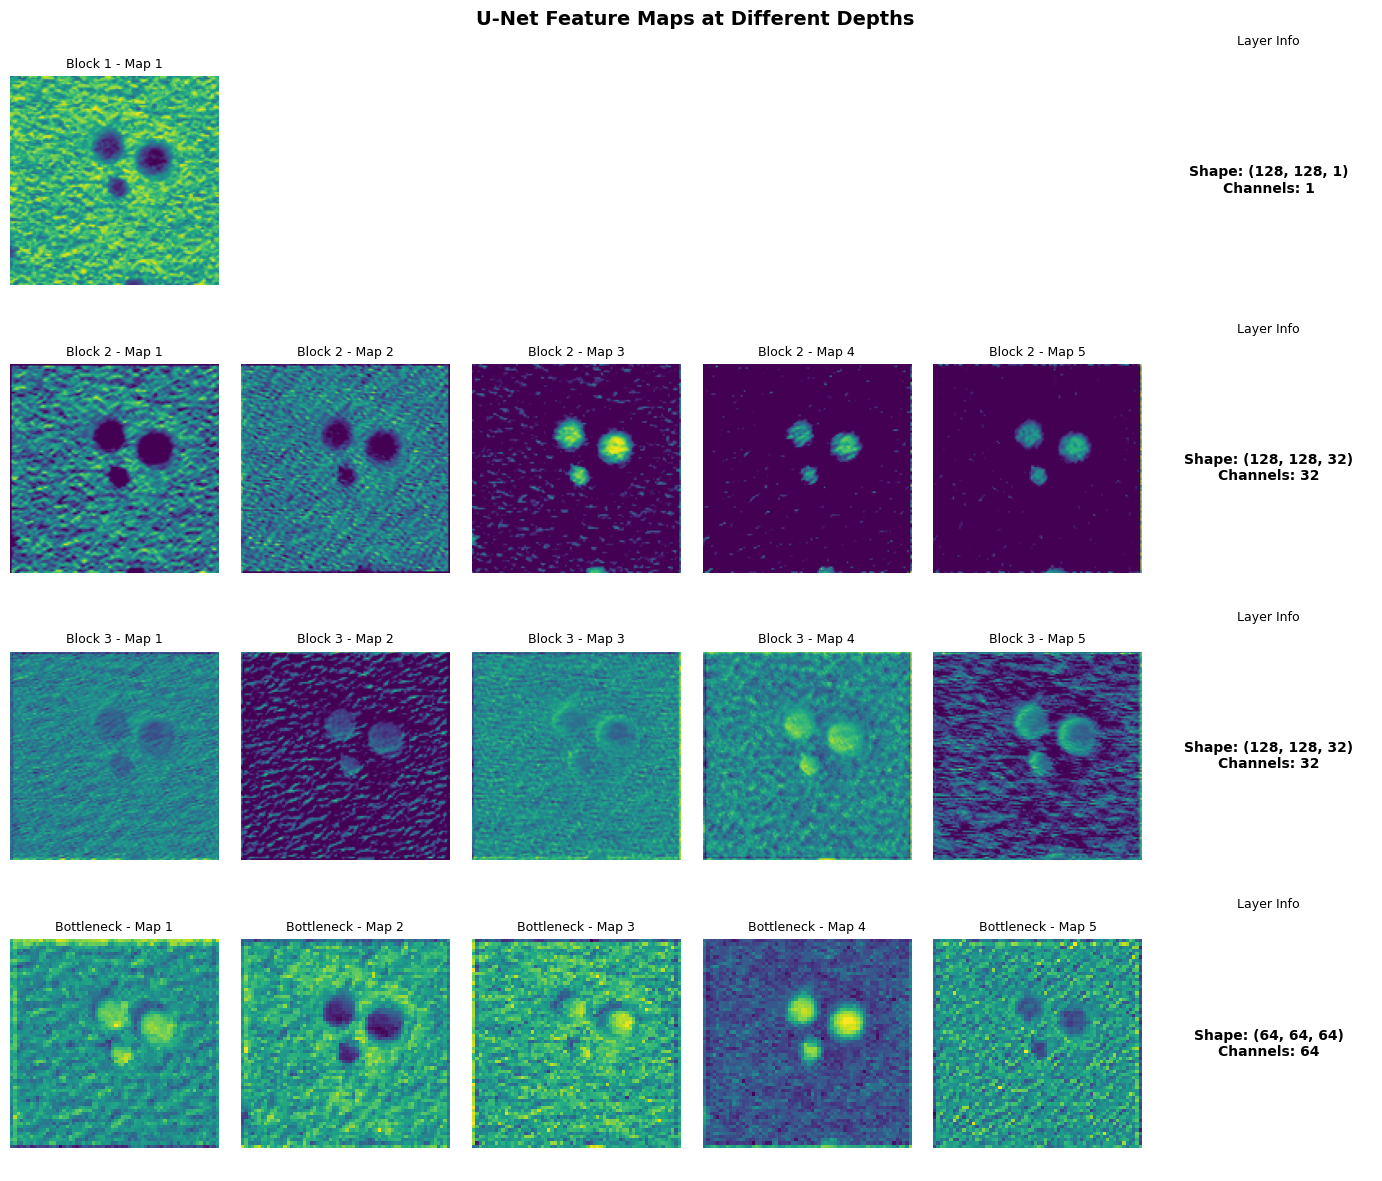

Feature map visualization complete!


In [51]:
# Extract intermediate feature maps from different layers
sample_image = X_test[0:1]

# Get layer indices for visualization (encoder layers)
# Layers 0, 3, 6 correspond to first convolution outputs in each encoder block
layer_indices = [0, 3, 6, 9]  # Different depths in encoder
layer_names = ['Block 1', 'Block 2', 'Block 3', 'Bottleneck']

fig, axes = plt.subplots(4, 6, figsize=(14, 12))
fig.suptitle('U-Net Feature Maps at Different Depths', fontsize=14, fontweight='bold')

for row, (layer_idx, layer_name) in enumerate(zip(layer_indices, layer_names)):
    # Create intermediate model
    intermediate_model = keras.Model(
        inputs=unet_model.input,
        outputs=unet_model.layers[layer_idx].output
    )
    
    # Get feature maps
    feature_maps = intermediate_model.predict(sample_image, verbose=0)
    
    # Plot first 5 feature maps
    for col in range(6):
        ax = axes[row, col]
        
        if col < min(5, feature_maps.shape[-1]):
            # Normalize feature map for visualization
            fmap = feature_maps[0, :, :, col]
            fmap_normalized = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-7)
            
            ax.imshow(fmap_normalized, cmap='viridis')
            ax.set_title(f'{layer_name} - Map {col+1}', fontsize=9)
        elif col == 5:
            # Last subplot shows shape info
            ax.text(0.5, 0.5, f'Shape: {feature_maps.shape[1:]}\n' + 
                            f'Channels: {feature_maps.shape[-1]}',
                   ha='center', va='center', fontsize=10, fontweight='bold')
            ax.set_title('Layer Info', fontsize=9)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

print("Feature map visualization complete!")
 

In [52]:

#
# 4. Evaluation metrics:
#    - CNN: F1-score = 2 * (precision * recall) / (precision + recall)
#    - U-Net: IoU = intersection / union, Dice = 2 * intersection / (A + B)
#    - Hint: Use sklearn.metrics.f1_score, precision_score, recall_score
#
# 5. Visualization:
#    - Plot training curves: plt.plot(history.history['loss'], label='train')
#    - Show ground truth vs predictions side by side
#    - Display intermediate feature maps from encoder layers


# TODO: define U-Net architecture 
unet_model = None


## Dataset: DOPAD (Dataset Of nanoPArticle Detection)

**Overview:**
- **272 original TEM images** at varying resolutions (~1.5M total particles)
- High-resolution nanoparticle detection annotations
- Diverse imaging environments and particle morphologies

**Note:** You do **not** need to use all 272 images. Using **100images** is sufficient for this assignment and will provide excellent statistical validation while keeping computational cost manageable.

**Download:** https://dopad.github.io/docs/download/

**Citation:** Qu et al. - For academic use, cite appropriately per repository guidelines.

## Deliverables Checklist
- [ ] Classical pipeline outputs (`classical_results.csv`, four-panel figure).
- [ ] ML analyses (`ml_results.csv`, confusion matrices, clustering visualizations).
- [ ] Deep learning artifacts (training curves, segmentation outputs, feature maps).
- [ ] Comparison table summarizing methods and metrics.
- [ ] Final 3×3 visualization collage.
- [ ] README.md documenting methodology, quantitative comparisons, and recommendations.
- [ ] Publication-quality figures with scale bars and repository submission.